In [15]:
import sys
import os
import pickle
from tqdm import tqdm
from topolearn import *
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")


In [229]:
prob_T=0.7

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1] # N2
nd = B1.shape[1] # N1
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu_true, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
B2_true = B2@G.mask
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity_mode = "random"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5,26,4)
K0_max = 25
max_iter = 100 
patience = 5 
tol = 1e-3 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

T_coll = [0.5, 0.6, 0.7, 0.8, 0.9]

In [28]:
path = os.getcwd()
s = 5
t = 50
name = f'T{t}_max{s}'
res = f"results\\final\\max_sparsity{s}\\res_separated_{name}.pkl"
with open(f"{path}\\{res}", "rb") as fff:
    models = pickle.load(fff)
    dict_errors = pickle.load(fff)

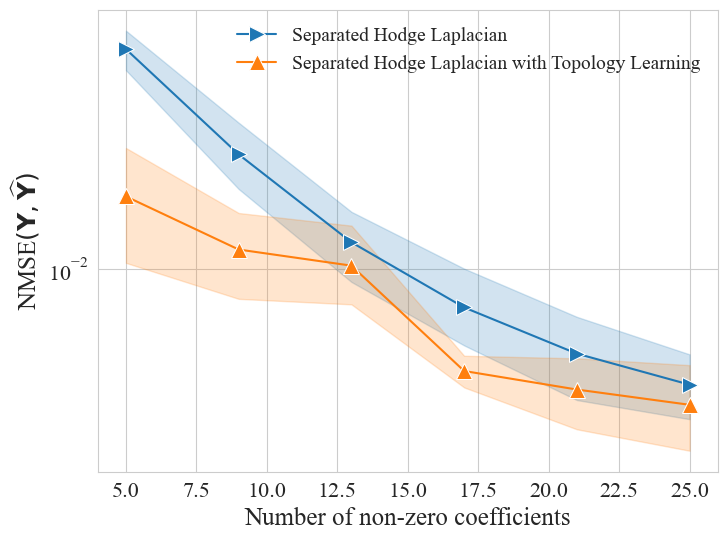

In [29]:
dict_types2 = {
    # "fourier": "Topological Fourier",
    # "edge": "Edge Laplacian",
    # "joint": "Joint Hodge Laplacian",
    "separated": "Separated Hodge Laplacian",
    "complete": "Separated Hodge Laplacian with Topology Learning",
    # "complete_pess": "Separated Hodge Laplacian with Pessimistic Topology Learning",
}
# TITLE = [dict_types[typ] for typ in dict_types.keys() if typ in dictionary_type][0]
res_df2 = pd.DataFrame()
for typ in dict_errors.keys():
    tmp_df2 = pd.DataFrame(dict_errors[typ][0])
    tmp_df2.columns = K0_coll
    tmp_df2 = tmp_df2.melt(var_name="Sparsity", value_name="Error")
    tmp_df2["Method"] = dict_types2[typ] if typ in dict_types2.keys() else None
    pass
    res_df2 = pd.concat([res_df2, tmp_df2]).reset_index(drop=True)

markers = (
    [">", "^", "v", "d"]
    if len(dict_errors.keys()) == 4
    else [">", "^", "v", "d", "s"]
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16  
plt.rcParams["font.size"] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams["font.family"] = "Times New Roman"
my_plt = sns.lineplot(
    data=res_df2,
    x="Sparsity",
    y="Error",
    hue="Method",
    palette=sns.color_palette()[: len(dict_errors)],
    markers=markers,
    markersize=12,
    dashes=False,
    style="Method",
)

my_plt.set(yscale="log")

my_plt.set_ylabel(r"NMSE$(\mathbf{Y},\widehat{\mathbf{Y}})$", fontsize=18)
my_plt.set_xlabel(f"Number of non-zero coefficients", fontsize=18)
handles, labels = my_plt.get_legend_handles_labels()
my_plt.legend(handles=handles[0:], labels=labels[0:])
plt.legend(
    fontsize=14,
    frameon=False,              # Display a frame around the legend
    framealpha=0.3              
)

plt.savefig(f"{name}.pdf", format="pdf")
plt.show()

In [185]:
def plot_error(list_, error=False, tmp=False):
    # Concatenate the arrays
    out = np.array([np.array(a) for a in list_])
    out = np.concatenate(out)

    # Initialize the start index
    start = 0

    # Create the plot
    plt.figure(figsize=(10, 5))

    # Loop through the original list_ to determine segment colors
    for idx, sub_array in enumerate(list_):
        end = start + len(sub_array)  # Determine the end index of the current segment
        if idx % 2 == 0:  # Even index
            color = 'red'
        else:  # Odd index
            color = 'blue'
        
        # Plot the segment
        plt.plot(range(start, end), out[start:end], color=color)
        
        if idx>0 and idx < len(list_)-1:  # Connect segments with a line
            plt.plot([start - 1, start], [out[start - 1], out[start]], color=color)

        start = end  # Update the start index for the next segment

    plt.xlabel("Iteration")
    if error:
        y_label = "MSE"
    else:
        y_label = "Objective Function"
    plt.ylabel(y_label)
    lab="(h, S)" if tmp else "(h, S, p)"
    plt.legend([f"{lab} optimization", "topology optimization"], loc="upper right")
    plt.show()

In [255]:
with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T70_max25.pkl", "rb") as fffr:
    models_max25_T70 = pickle.load(fffr)
    dict_errors_max25_T70 = pickle.load(fffr)

In [177]:
# with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T70_max25_tmp.pkl", "wb") as rr:
#     pickle.dump(models_max25_T70, rr)
#     pickle.dump(dict_errors_max25_T70, rr)

with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T70_max25_tmp.pkl", "rb") as fffr:
    models_max25_T70_tmp = pickle.load(fffr)
    dict_errors_max25_T70_tmp = pickle.load(fffr)

In [225]:
p = models_max25_T70[(0, i)][0].p

In [227]:
print(np.sum(p) / p.shape[0])

0.6935483870967742


In [238]:
p_star=np.where(np.sum(B2_true, axis=0)>0, np.sum(B2_true, axis=0), 0)

In [242]:
np.all(B2@np.diag(p_star)==B2_true)

True

In [239]:
p == p_star

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

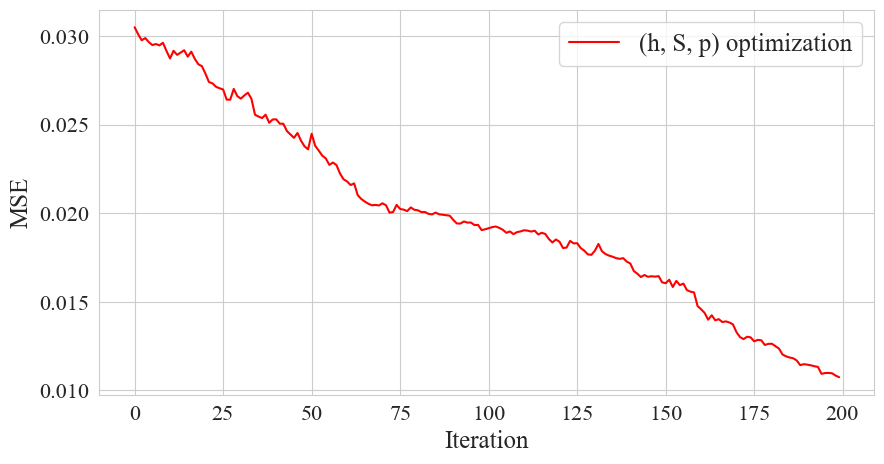

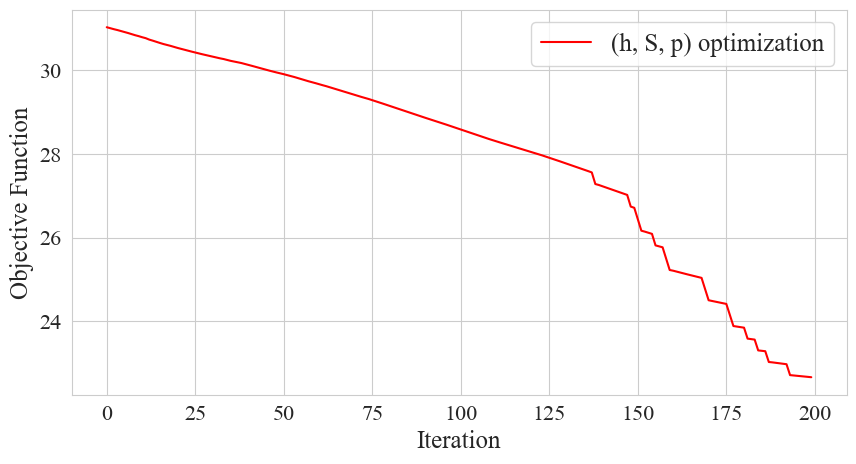

In [259]:
i=5

list1= models_max25_T70[(0, i)][0].train_error_hist
list2= models_max25_T70[(0, i)][0].train_history

plot_error(list1, error=True)
plot_error(list2)

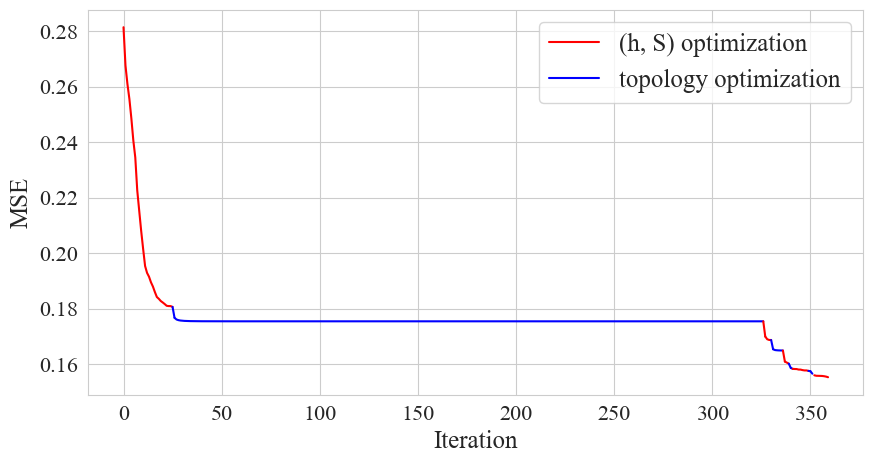

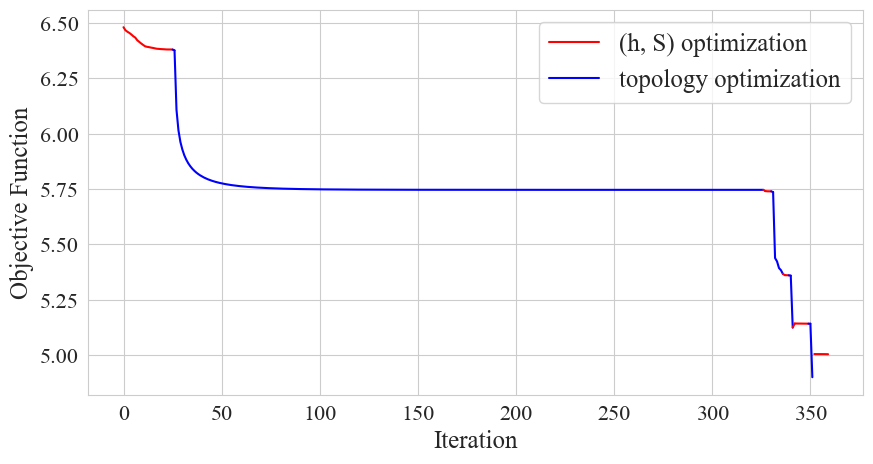

In [190]:
list1= models_max25_T70_tmp[(0, i)][1].train_error_hist
list2= models_max25_T70_tmp[(0, i)][1].train_history

plot_error(list1, error=True, tmp=True)
plot_error(list2, tmp=True)